In [1]:
import pandas as pd
import numpy as np
import glob
import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
BAVED_PATH = '/content/drive/MyDrive/baved'

baved_emotion = []
baved_gender = []
baved_path = []

for keyword_folder in range(7):
    keyword_folder_path = os.path.join(BAVED_PATH, str(keyword_folder))
    if os.path.isdir(keyword_folder_path):
        for file_path in glob.glob(os.path.join(keyword_folder_path, '*.wav')):
            filename = os.path.basename(file_path)
            speaker_id, speaker_gender, speaker_age, spoken_word, spoken_emotion, record_id = filename[:-4].split('-')

            # Map spoken_word and spoken_emotion values to the corresponding labels
            if speaker_gender == 'm':
                if spoken_word in ['0', '3'] and spoken_emotion == '0':
                    emotion_label = 'male_fear'
                elif spoken_word in ['1', '2', '4'] and spoken_emotion == '0':
                    emotion_label = 'male_sad'
                elif spoken_word in ['5', '6'] and spoken_emotion == '0':
                    emotion_label = 'male_disgust'
                elif spoken_emotion == '1':
                    emotion_label = 'male_neutral'
                elif spoken_word in ['0', '4'] and spoken_emotion == '2':
                    emotion_label = 'male_happy'
                elif spoken_word == '6' and spoken_emotion == '2':
                    emotion_label = 'male_angry'
                elif spoken_word == '5' and spoken_emotion == '2':
                    emotion_label = 'male_surprised'
                else:
                    emotion_label = 'male_error'
            elif speaker_gender == 'f':
                if spoken_word in ['0', '3'] and spoken_emotion == '0':
                    emotion_label = 'female_fear'
                elif spoken_word in ['1', '2', '4'] and spoken_emotion == '0':
                    emotion_label = 'female_sad'
                elif spoken_word in ['5', '6'] and spoken_emotion == '0':
                    emotion_label = 'female_disgust'
                elif spoken_emotion == '1':
                    emotion_label = 'female_neutral'
                elif spoken_word in ['0', '4'] and spoken_emotion == '2':
                    emotion_label = 'female_happy'
                elif spoken_word == '6' and spoken_emotion == '2':
                    emotion_label = 'female_angry'
                elif spoken_word == '5' and spoken_emotion == '2':
                    emotion_label = 'female_surprised'
                else:
                    emotion_label = 'female_error'
            else:
                emotion_label = 'error'

            baved_emotion.append(emotion_label)
            baved_gender.append(speaker_gender)
            baved_path.append(file_path)

# dataframe for emotion of files
emotion_df = pd.DataFrame(baved_emotion, columns=['labels'])
# dataframe for path of files.
path_df = pd.DataFrame(baved_path, columns=['path'])

BAVED_df = pd.concat([ path_df, emotion_df], axis=1)
BAVED_df = BAVED_df[BAVED_df['labels'] != 'male_error']
BAVED_df = BAVED_df[BAVED_df['labels'] != 'female_error']
BAVED_df = BAVED_df.reset_index(drop=True)

In [32]:
data_path = pd.concat([BAVED_df], axis = 0)
data_path = data_path.reset_index(drop=True)
data_path.head()

,path,labels
0,/content/drive/MyDrive/baved/0/18-m-21-0-2-118...,male_happy
1,/content/drive/MyDrive/baved/0/14-m-23-0-1-110...,male_neutral
2,/content/drive/MyDrive/baved/0/11-m-23-0-0-108...,male_fear
3,/content/drive/MyDrive/baved/0/15-m-24-0-2-112...,male_happy
4,/content/drive/MyDrive/baved/0/0-m-21-0-1-105.wav,male_neutral


In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data_path['encoded_labels'] = label_encoder.fit_transform(data_path['labels'])


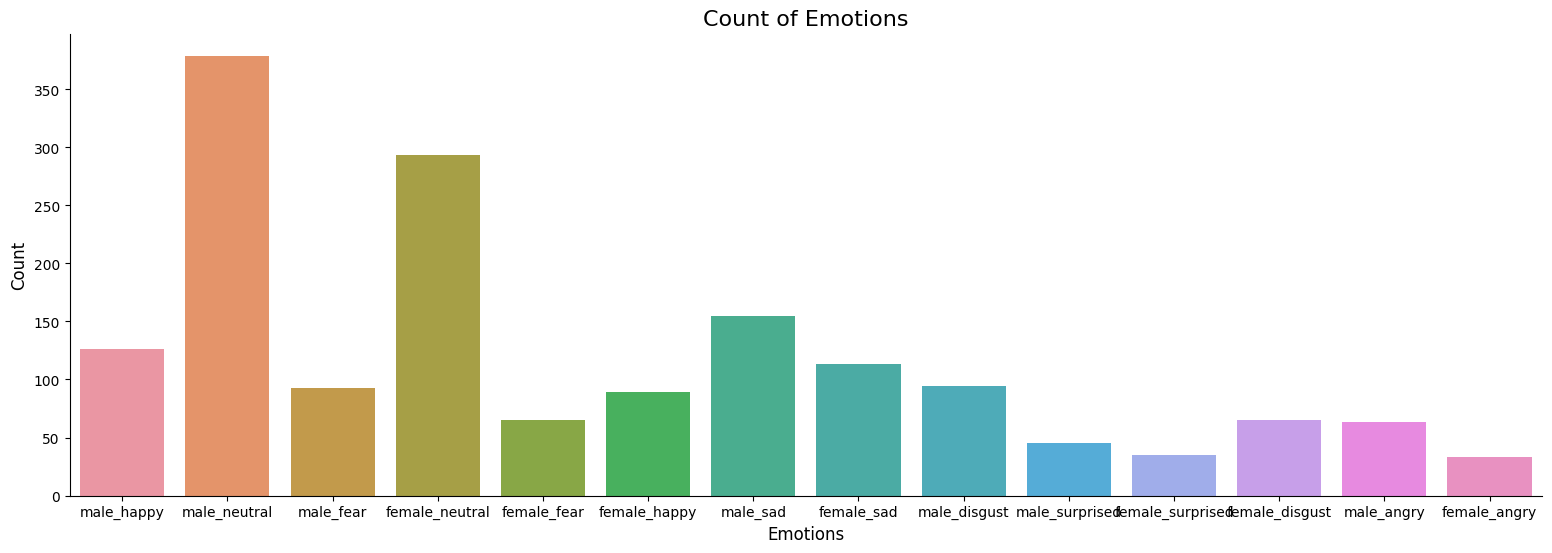

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# ...

plt.figure(figsize=(19, 6))  # Adjust the figure size if needed

plt.title('Count of Emotions', size=16)
sns.countplot(data=data_path, x='labels')

# Adjust the width of the bars to add space
plt.bar_width = 0.8  # Adjust the value as per your preference

plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [11]:
import matplotlib.pyplot as plt
import librosa

def create_waveplot(data, sr, e):
    plt.figure(figsize=(7, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=12)
    plt.plot(data)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(7, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=12)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

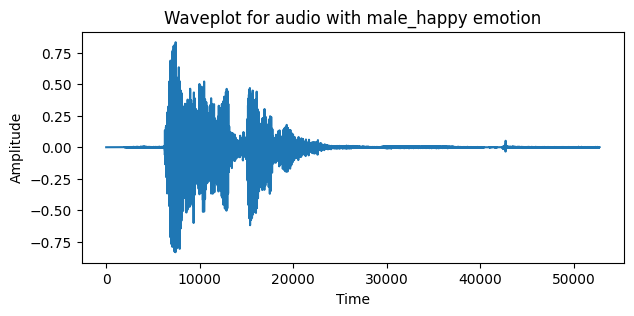

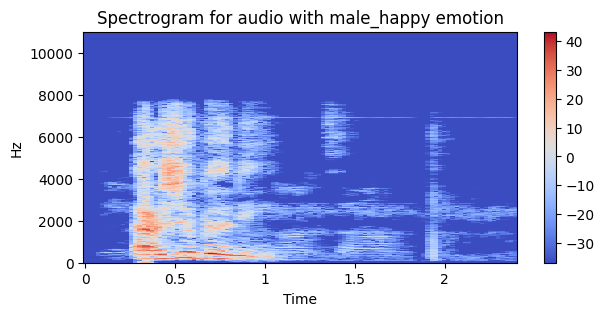

In [12]:
emotion='male_happy'
path = np.array(data_path.path[data_path.labels==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

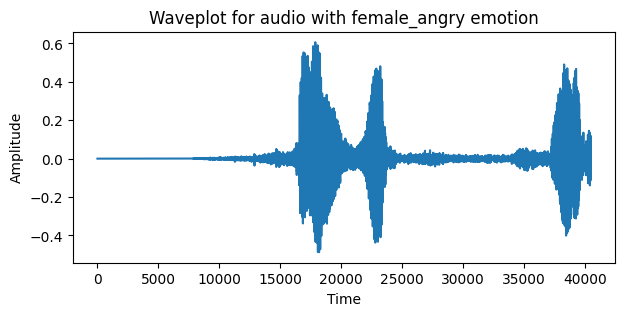

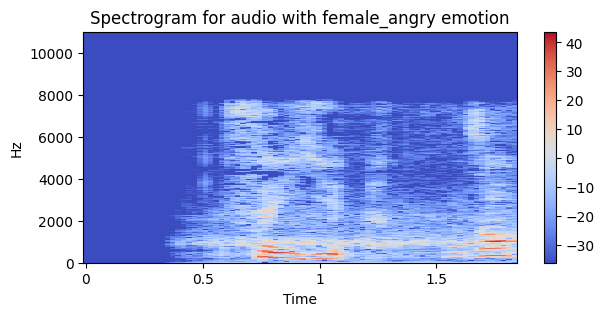

In [13]:
emotion='female_angry'
path = np.array(data_path.path[data_path.labels==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

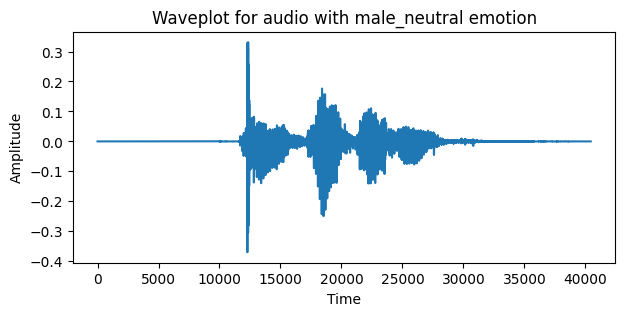

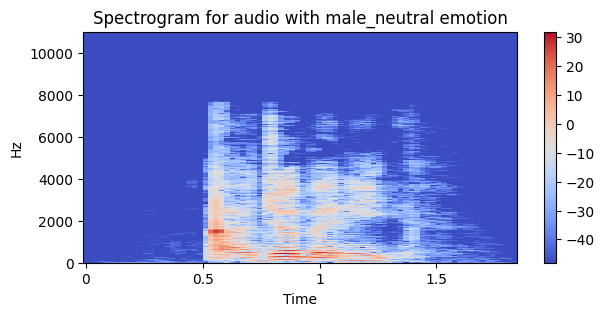

In [14]:
emotion='male_neutral'
path = np.array(data_path.path[data_path.labels==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [15]:
def extract_mfcc(filename):
    y,sr=librosa.load(filename,duration=3,offset=0.5)
    mfcc=np.mean(librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40).T,axis=0)
    return mfcc

In [16]:
extract_mfcc(data_path['path'][0])

array([-3.98475983e+02,  9.88498840e+01, -2.10284271e+01,  2.12762947e+01,
        6.70976448e+00, -9.55170691e-01, -2.97296982e+01,  4.50946712e+00,
        3.34553766e+00, -1.32078915e+01,  4.54741573e+00, -9.01164722e+00,
        2.97036028e+00, -1.49441600e+00, -2.36042953e+00,  1.59587884e+00,
       -6.64151812e+00, -3.22817087e-01, -9.93218958e-01, -3.17350149e+00,
       -4.25074434e+00, -1.57086885e+00, -4.95539570e+00, -3.38789701e+00,
       -6.79474697e-02, -5.94932699e+00, -1.28042400e+00,  4.50517356e-01,
       -2.07486534e+00,  5.33111513e-01,  1.58675119e-01, -2.92830133e+00,
       -1.03866786e-01, -1.08687055e+00, -3.47073913e+00, -1.43087327e+00,
       -5.46529436e+00, -4.72654724e+00, -1.13715053e+00, -8.07658911e-01],
      dtype=float32)

In [17]:
x_mfcc = data_path['path'].apply(lambda x: extract_mfcc(x) if os.path.exists(x) else None)

In [18]:
x_mfcc

0       [-398.47598, 98.849884, -21.028427, 21.276295,...
1       [-366.14417, 124.03819, -22.174065, 28.988394,...
2       [-503.09576, 125.30556, -8.236112, 38.39981, -...
3       [-406.63068, 69.17078, -7.112802, 17.817163, -...
4       [-433.00388, 111.4059, -26.30458, 45.901173, -...
                              ...                        
1643    [-316.24283, 93.041855, -27.692087, 52.007954,...
1644    [-222.42036, 81.50219, -47.58829, 71.359726, -...
1645    [-342.5189, 125.14811, -28.25729, 41.663208, 1...
1646    [-302.17386, 86.12525, -38.21381, 48.399216, -...
1647    [-460.73514, 135.62308, -24.497469, 54.26494, ...
Name: path, Length: 1648, dtype: object

In [19]:
X=[x for x in x_mfcc]
X=np.asarray(X[1:],dtype=np.float32)
X.shape

(1647, 40)

In [20]:
X=np.expand_dims(X,-1)
X.shape

(1647, 40, 1)

In [21]:
from keras.utils import to_categorical
y=to_categorical(data_path['encoded_labels'])
y.shape

(1648, 14)

In [22]:
X = X.reshape(X.shape[0], X.shape[1], 1)

In [23]:
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense,LSTM,Dropout

model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(40, 1)),
    LSTM(128, return_sequences=False),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(14, activation='softmax')
])


# Define a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 256)           264192    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2

In [24]:
history = model.fit(X, y, validation_split=0.2, epochs=64, batch_size=128, shuffle=True, callbacks=[lr_scheduler])

Epoch 1/64
11/11 [==============================] - 8s 410ms/step - loss: 2.5438 - accuracy: 0.1792 - val_loss: 2.7206 - val_accuracy: 0.1758 - lr: 0.0010
Epoch 2/64
11/11 [==============================] - 4s 343ms/step - loss: 2.4508 - accuracy: 0.2118 - val_loss: 2.7737 - val_accuracy: 0.1758 - lr: 0.0010
Epoch 3/64
11/11 [==============================] - 3s 309ms/step - loss: 2.4062 - accuracy: 0.2134 - val_loss: 2.8099 - val_accuracy: 0.1758 - lr: 0.0010
Epoch 4/64
11/11 [==============================] - 3s 306ms/step - loss: 2.3812 - accuracy: 0.2012 - val_loss: 2.8985 - val_accuracy: 0.1758 - lr: 0.0010
Epoch 5/64
11/11 [==============================] - 4s 385ms/step - loss: 2.3705 - accuracy: 0.2058 - val_loss: 2.8882 - val_accuracy: 0.1697 - lr: 0.0010
Epoch 6/64
11/11 [==============================] - 3s 310ms/step - loss: 2.3376 - accuracy: 0.2149 - val_loss: 3.0534 - val_accuracy: 0.1818 - lr: 0.0010
Epoch 7/64
11/11 [==============================] - 3s 305ms/step - lo

In [25]:
predit =extract_mfcc('/content/drive/MyDrive/baved/3/101-m-20-3-1-46.wav')
print(predit)
predit=np.asarray(predit,dtype=np.float32)
predit.shape
predit=np.expand_dims(predit,-1)
print(predit.shape)
print(model.predict(predit))

[-337.94113     118.02372       7.330593     43.732285      4.810507
   23.07926     -27.744408     -0.68218875   -8.561711    -11.050876
   -9.574896    -15.616677    -11.820866     -5.551732     11.456957
  -13.881205      3.7370465     1.5983995     0.734387      2.6539798
   -5.48577       0.7719059    -4.03344      -0.53020906   -7.324058
   -5.471749     -1.4053072    -0.40566817   -1.1634878    -2.0294497
   -3.120777     -1.7535765    -0.35436192   -2.0487466    -1.8230957
   -3.856688     -1.8635846    -4.4567738    -2.4371374    -2.2721224 ]
(40, 1)
2/2 [==============================] - 1s 8ms/step
[[0.04938225 0.04607741 0.07156206 0.06933127 0.11812861 0.07823696
  0.04912175 0.03610995 0.04748199 0.07378079 0.07970425 0.12520659
  0.10070101 0.05517514]
 [0.05968174 0.05531957 0.06460602 0.07118437 0.09846996 0.07891008
  0.05987791 0.0562442  0.05925644 0.06562893 0.07709222 0.10033964
  0.09431682 0.05907209]
 [0.06287844 0.06095015 0.06688567 0.07346611 0.0882327  0.07

In [26]:
X_subset = X[:1647]
y_subset = y[:1647]

# Evaluate model on test data
loss, accuracy = model.evaluate(X_subset, y_subset)

print('Test Loss:', loss)
print('Test Accuracy:', accuracy)


52/52 [==============================] - 3s 52ms/step - loss: 2.3967 - accuracy: 0.2392
Test Loss: 2.396700143814087
Test Accuracy: 0.23922282457351685


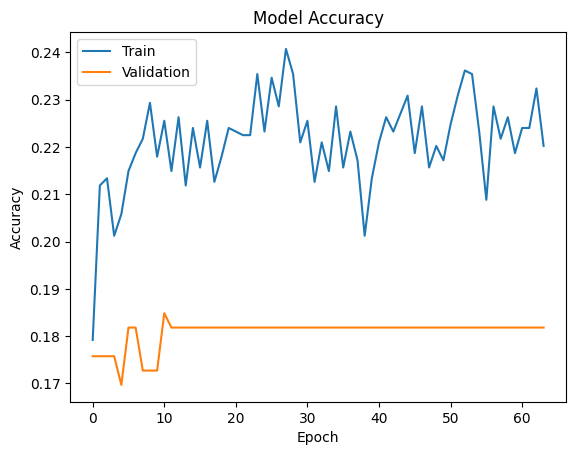

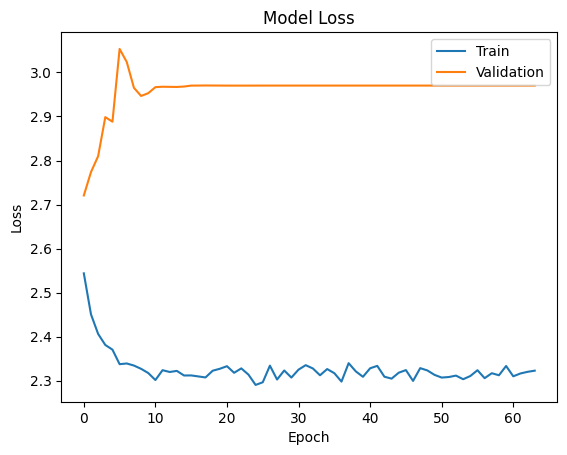

In [27]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


52/52 [==============================] - 1s 14ms/step


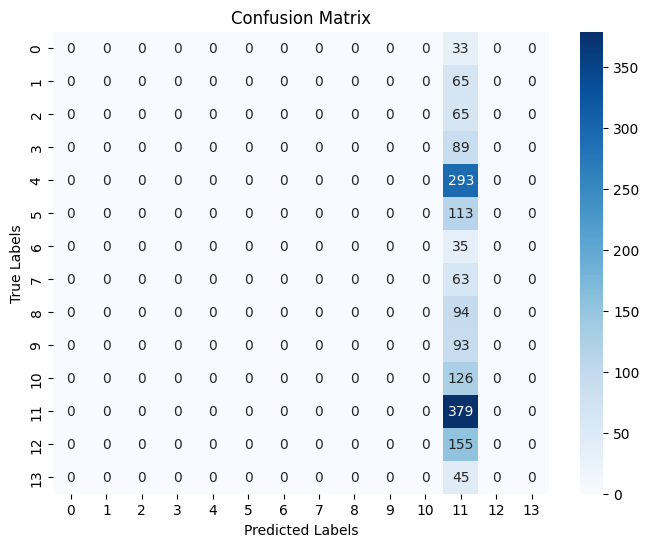

In [28]:
# Make predictions on test data
y_pred = model.predict(y)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y.argmax(axis=1), y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


NameError: ignored

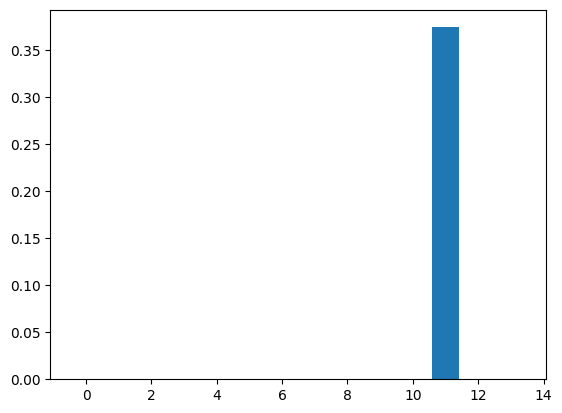

In [29]:
from sklearn.metrics import f1_score

# Calculate F1 scores
f1_scores = f1_score(y.argmax(axis=1), y_pred_labels, average=None)

# Plot F1 scores
plt.bar(range(len(f1_scores)), f1_scores)
plt.xticks(range(len(f1_scores)), labels)
plt.title('F1 Score by Class')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.show()
